VERIFICAÇÃO DO DATASET

In [42]:
# Verificar os nomes das colunas no dataset
print("Colunas disponíveis no dataset:", df.columns)


Colunas disponíveis no dataset: Index(['COMPOSTO', 'CATION', 'ANION', 'pKs', 'CARGA', 'RAIO_IONICO',
       'E_IONIZACAO', 'COMPOSTO_ENCODED', 'CATION_ENCODED', 'ANION_ENCODED'],
      dtype='object')


IMPORTAÇÃO DO DATASET

In [43]:
import os
import pandas as pd

# Garantir que o dataset esteja na mesma pasta do código
current_dir = os.getcwd()  # Obtém o diretório atual
dataset_path = os.path.join(current_dir, 'Dataset_Ultra_Expandido.csv')

# Carregar o dataset
df = pd.read_csv(dataset_path)

# Função para tokenizar fórmulas químicas
def tokenize_formula(formula):
    import re
    tokens = re.findall(r'[A-Z][a-z]?|\d+', formula)
    return tokens

# Aplicar a tokenização às colunas de interesse
for col in ['COMPOSTO', 'CATION', 'ANION']:
    df[f'{col}_TOKENS'] = df[col].apply(tokenize_formula)

# Mostrar resultado
print(df.head())

# Salvar o dataset processado (opcional)
processed_path = os.path.join(current_dir, 'Dataset_Tokenized.csv')
df.to_csv(processed_path, index=False)


    COMPOSTO CATION    ANION    pKs  CARGA  RAIO_IONICO  E_IONIZACAO  \
0      CaCO3  Ca 2+  CO3 2-    8.54      2          1.0        11.87   
1       CaF2  Ca 2+     F 1-   8.28      2          1.0        11.87   
2  Ca3(PO4)2  Ca 2+   PO4 3-  15.00      2          1.0        11.87   
3      CaSO4  Ca 2+   SO4 2-   4.31      2          1.0        11.87   
4     CaCrO4  Ca 2+  CrO4 2-   3.15      2          1.0        11.87   

   COMPOSTO_ENCODED  CATION_ENCODED  ANION_ENCODED      COMPOSTO_TOKENS  \
0                17               3              3        [Ca, C, O, 3]   
1                19               3              6           [Ca, F, 2]   
2                16               3             10  [Ca, 3, P, O, 4, 2]   
3                22               3             13        [Ca, S, O, 4]   
4                18               3              5       [Ca, Cr, O, 4]   

  CATION_TOKENS   ANION_TOKENS  
0       [Ca, 2]   [C, O, 3, 2]  
1       [Ca, 2]         [F, 1]  
2       [Ca, 2]  

IMPORTAÇÃO DE BIBLIOTECAS PARA NORMALIZAR O DATASET E RESOLVER PROBLEMAS COMO VARIAVEIS COM LETRAS E NÚMEROS

In [45]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Função para realizar One-Hot Encoding
def one_hot_encode_tokens(df, column):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Atualizado para sparse_output
    # Flattening os tokens para serem usados no One-Hot Encoder
    all_tokens = np.concatenate(df[column].values)
    all_tokens = all_tokens.reshape(-1, 1)  # Ajusta para formato esperado
    encoded = encoder.fit_transform(all_tokens)
    
    # Criar um DataFrame com os valores codificados
    token_columns = [f"{column}_{cat}" for cat in encoder.categories_[0]]
    encoded_df = pd.DataFrame(encoded, columns=token_columns)
    
    return encoded_df

# Aplicar o One-Hot Encoding em cada coluna de tokens
encoded_columns = []
for col in ['COMPOSTO_TOKENS', 'CATION_TOKENS', 'ANION_TOKENS']:
    encoded_df = one_hot_encode_tokens(df, col)
    encoded_columns.append(encoded_df)

# Concatenar todas as colunas codificadas no dataset original
df_encoded = pd.concat([df] + encoded_columns, axis=1)

# Salvar o dataset processado com os One-Hot Encodings
encoded_path = os.path.join(current_dir, 'Dataset_Encoded.csv')
df_encoded.to_csv(encoded_path, index=False)

print("Processamento completo! Dataset salvo como 'Dataset_Encoded.csv'")


Processamento completo! Dataset salvo como 'Dataset_Encoded.csv'


PRIMEIROS TREINOS

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Selecionar apenas as colunas numéricas
numeric_columns = df_encoded.select_dtypes(include=['float64', 'int64']).columns
features = df_encoded[numeric_columns].drop(columns=['pKs'])  # Excluir o target
target = df_encoded['pKs']

# Normalizar os dados (apenas as features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)

# Mostrar as dimensões dos conjuntos gerados
print("Conjunto de treinamento (X_train):", X_train.shape)
print("Conjunto de teste (X_test):", X_test.shape)


Conjunto de treinamento (X_train): (406, 68)
Conjunto de teste (X_test): (102, 68)


In [49]:
# Verificar valores ausentes no target
print("Valores ausentes em y_train:", y_train.isna().sum())
print("Valores ausentes em y_test:", y_test.isna().sum())

# Remover amostras com NaN em y_train e y_test
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

X_test = X_test[~y_test.isna()]
y_test = y_test.dropna()

# Confirmar que não há mais NaN
print("Após tratamento:")
print("Valores ausentes em y_train:", y_train.isna().sum())
print("Valores ausentes em y_test:", y_test.isna().sum())


Valores ausentes em y_train: 271
Valores ausentes em y_test: 67
Após tratamento:
Valores ausentes em y_train: 0
Valores ausentes em y_test: 0


AVALIANDO ERRO DO MODELO

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Instanciar o modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred = rf_model.predict(X_test)

# Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Random Forest - Avaliação do Modelo:")
print(f"Erro Médio Absoluto (MAE): {mae}")
print(f"Erro Médio Quadrático (MSE): {mse}")


Random Forest - Avaliação do Modelo:
Erro Médio Absoluto (MAE): 1.0907942857142854
Erro Médio Quadrático (MSE): 4.800918701142859


In [1]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl (390.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Carregar o dataset processado (encoded)
import pandas as pd
import os

current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'Dataset_Encoded.csv')
df_encoded = pd.read_csv(dataset_path)

# Selecionar apenas as colunas numéricas
numeric_columns = df_encoded.select_dtypes(include=['float64', 'int64']).columns
features = df_encoded[numeric_columns].drop(columns=['pKs'])  # Excluir o target
target = df_encoded['pKs']

# Normalizar os dados (apenas as features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)


VERIFICAÇÃO DE VALORES NULOS QUE DIFICUTAM A PASSAGEM NA REDE NEURAL

In [9]:
import numpy as np

# Verificar valores extremos ou NaN
print("Valores máximos por feature:", np.max(X_train, axis=0))
print("Valores mínimos por feature:", np.min(X_train, axis=0))
print("Valores NaN em X_train:", np.isnan(X_train).sum())
print("Valores NaN em y_train:", np.isnan(y_train).sum())


Valores máximos por feature: [        nan         nan         nan         nan         nan         nan
  2.24669069  4.81564909  4.4907312   8.45998987  5.21749195  6.42910051
  5.94017797  5.37423045  5.37423045  3.5168766  11.22497216  6.17065013
  4.93963561 11.22497216 10.02995513  5.94017797  5.94017797  5.54526825
  5.21749195 15.90597372 22.5166605   6.17065013 12.97433364  2.63391344
  8.45998987 22.5166605   6.17065013  3.99165797  5.94017797         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan]
Valores mínimos por feature: [        nan         nan         nan         nan         nan         nan
 -0.4450991  -0.20765633 -0.22268089 -0.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
from tensorflow.keras.regularizers import l2

ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)  # Saída para prever pKs
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


C:\Users\idmpi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
history = ann_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - l

In [13]:
# Imprimir a perda por época
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
print("Perda durante o treinamento:", loss_values)
print("Perda na validação:", val_loss_values)


Perda durante o treinamento: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Perda na validação: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [15]:
import pandas as pd

# Carregar o dataset
dataset_path = 'Dataset_Tokenized.csv'  # Certifique-se de que o arquivo está na mesma pasta
df = pd.read_csv(dataset_path)

# Verificar valores NaN em cada coluna do dataset
nan_counts = df.isna().sum()
print("Colunas com valores NaN e suas quantidades:")
print(nan_counts[nan_counts > 0])  # Mostrar apenas colunas com NaN

# Escolha uma das opções abaixo para tratar os valores NaN:

# Opção 1: Remover linhas com NaN (simples, mas reduz o dataset)
# df = df.dropna()

# Opção 2: Preencher NaN com a média (para colunas numéricas)
# df = df.fillna(df.mean())

# Exibir informações após o tratamento
print("\nDataset após tratamento:")
print(df.info())


Colunas com valores NaN e suas quantidades:
Series([], dtype: int64)

Dataset após tratamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   COMPOSTO          170 non-null    object 
 1   CATION            170 non-null    object 
 2   ANION             170 non-null    object 
 3   pKs               170 non-null    float64
 4   CARGA             170 non-null    int64  
 5   RAIO_IONICO       170 non-null    float64
 6   E_IONIZACAO       170 non-null    float64
 7   COMPOSTO_ENCODED  170 non-null    int64  
 8   CATION_ENCODED    170 non-null    int64  
 9   ANION_ENCODED     170 non-null    int64  
 10  COMPOSTO_TOKENS   170 non-null    object 
 11  CATION_TOKENS     170 non-null    object 
 12  ANION_TOKENS      170 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 17.4+ KB
None


In [16]:
df = df.dropna()


VERIFICAÇÃO SE O DATASET ESTÁ CORRETO AGORA

In [18]:
print("Tipos de dados no dataset:")
print(df.dtypes)

# Contar colunas numéricas e não numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = df.select_dtypes(exclude=['float64', 'int64']).columns

print("\nColunas numéricas:", numeric_columns.tolist())
print("\nColunas não numéricas:", non_numeric_columns.tolist())


Tipos de dados no dataset:
COMPOSTO             object
CATION               object
ANION                object
pKs                 float64
CARGA                 int64
RAIO_IONICO         float64
E_IONIZACAO         float64
COMPOSTO_ENCODED      int64
CATION_ENCODED        int64
ANION_ENCODED         int64
COMPOSTO_TOKENS      object
CATION_TOKENS        object
ANION_TOKENS         object
dtype: object

Colunas numéricas: ['pKs', 'CARGA', 'RAIO_IONICO', 'E_IONIZACAO', 'COMPOSTO_ENCODED', 'CATION_ENCODED', 'ANION_ENCODED']

Colunas não numéricas: ['COMPOSTO', 'CATION', 'ANION', 'COMPOSTO_TOKENS', 'CATION_TOKENS', 'ANION_TOKENS']


In [19]:
# Selecionar apenas colunas numéricas
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Tratar valores NaN (preencher com a média, por exemplo)
df_numeric = df_numeric.fillna(df_numeric.mean())

print("\nDataset após selecionar colunas numéricas e tratar NaN:")
print(df_numeric.info())



Dataset após selecionar colunas numéricas e tratar NaN:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pKs               170 non-null    float64
 1   CARGA             170 non-null    int64  
 2   RAIO_IONICO       170 non-null    float64
 3   E_IONIZACAO       170 non-null    float64
 4   COMPOSTO_ENCODED  170 non-null    int64  
 5   CATION_ENCODED    170 non-null    int64  
 6   ANION_ENCODED     170 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 9.4 KB
None


VERIFICAR SE A VETORIZAÇÃO DAS VARIAVEIS NÃO ALTEROU NO PADRÃO PRINCIPAL DO DATASET

In [20]:
# Carregar o dataset
import pandas as pd
dataset_path = 'Dataset_Tokenized.csv'  # Certifique-se de que o arquivo está na mesma pasta
df = pd.read_csv(dataset_path)

# Diagnosticar tipos de dados
print("Tipos de dados no dataset:")
print(df.dtypes)

# Identificar colunas numéricas e não numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = df.select_dtypes(exclude=['float64', 'int64']).columns

print("\nColunas numéricas:", numeric_columns.tolist())
print("\nColunas não numéricas:", non_numeric_columns.tolist())


Tipos de dados no dataset:
COMPOSTO             object
CATION               object
ANION                object
pKs                 float64
CARGA                 int64
RAIO_IONICO         float64
E_IONIZACAO         float64
COMPOSTO_ENCODED      int64
CATION_ENCODED        int64
ANION_ENCODED         int64
COMPOSTO_TOKENS      object
CATION_TOKENS        object
ANION_TOKENS         object
dtype: object

Colunas numéricas: ['pKs', 'CARGA', 'RAIO_IONICO', 'E_IONIZACAO', 'COMPOSTO_ENCODED', 'CATION_ENCODED', 'ANION_ENCODED']

Colunas não numéricas: ['COMPOSTO', 'CATION', 'ANION', 'COMPOSTO_TOKENS', 'CATION_TOKENS', 'ANION_TOKENS']


In [21]:
# Selecionar apenas colunas numéricas
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Preencher valores NaN com a média das colunas
df_numeric = df_numeric.fillna(df_numeric.mean())

print("\nDataset após selecionar colunas numéricas e tratar NaN:")
print(df_numeric.info())



Dataset após selecionar colunas numéricas e tratar NaN:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pKs               170 non-null    float64
 1   CARGA             170 non-null    int64  
 2   RAIO_IONICO       170 non-null    float64
 3   E_IONIZACAO       170 non-null    float64
 4   COMPOSTO_ENCODED  170 non-null    int64  
 5   CATION_ENCODED    170 non-null    int64  
 6   ANION_ENCODED     170 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 9.4 KB
None


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Definir features e target
features = df_numeric.drop(columns=['pKs'])  # Certifique-se de que 'pKs' é o nome correto da variável alvo
target = df_numeric['pKs']

# Normalizar as features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42
)


CONTINUAÇÃO DO TREINO E APLICAÇÕES NAS REDES

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Construção da Rede Neural
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Saída para prever pKs
])

# Compilar o modelo
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Treinar o modelo
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Previsão no conjunto de teste
y_pred_ann = ann_model.predict(X_test).flatten()

# Avaliação do modelo
mae_ann = mean_absolute_error(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)

print("\nRedes Neurais Artificiais - Avaliação do Modelo:")
print(f"Erro Médio Absoluto (MAE): {mae_ann}")
print(f"Erro Médio Quadrático (MSE): {mse_ann}")


Epoch 1/50


C:\Users\idmpi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 83.7096 - mae: 8.8346 - val_loss: 90.2820 - val_mae: 9.1754
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 79.1394 - mae: 8.5991 - val_loss: 86.6529 - val_mae: 8.9789
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 74.5342 - mae: 8.3308 - val_loss: 83.0781 - val_mae: 8.7810
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 77.7361 - mae: 8.4567 - val_loss: 79.4313 - val_mae: 8.5744
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 70.2720 - mae: 8.0384 - val_loss: 75.5955 - val_mae: 8.3508
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 64.2335 - mae: 7.6211 - val_loss: 71.6305 - val_mae: 8.1164
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 61.1452 - mae: 7.5128 - val_loss: 67.6214 - val_mae: 7.8869
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 61.0074 - mae: 7.4037 - val_loss: 63.4544 - val_mae: 7.6402
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 54.3220 - mae: 6.

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Instanciar o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo
rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred_rf = rf_model.predict(X_test)

# Avaliar o modelo
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Random Forest - Avaliação do Modelo:")
print(f"Erro Médio Absoluto (MAE): {mae_rf}")
print(f"Erro Médio Quadrático (MSE): {mse_rf}")


Random Forest - Avaliação do Modelo:
Erro Médio Absoluto (MAE): 1.0094309227537233
Erro Médio Quadrático (MSE): 3.570634430176273


In [25]:
# Comparação dos Resultados
print("\nComparação de Modelos:")
print(f"Rede Neural - MAE: {mae_ann}, MSE: {mse_ann}")
print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}")

# Melhor Modelo com Base no MAE
melhor_modelo = "Rede Neural" if mae_ann < mae_rf else "Random Forest"
print(f"\nMelhor modelo com base no MAE: {melhor_modelo}")



Comparação de Modelos:
Rede Neural - MAE: 1.608293602887322, MSE: 7.120648111933749
Random Forest - MAE: 1.0094309227537233, MSE: 3.570634430176273

Melhor modelo com base no MAE: Random Forest


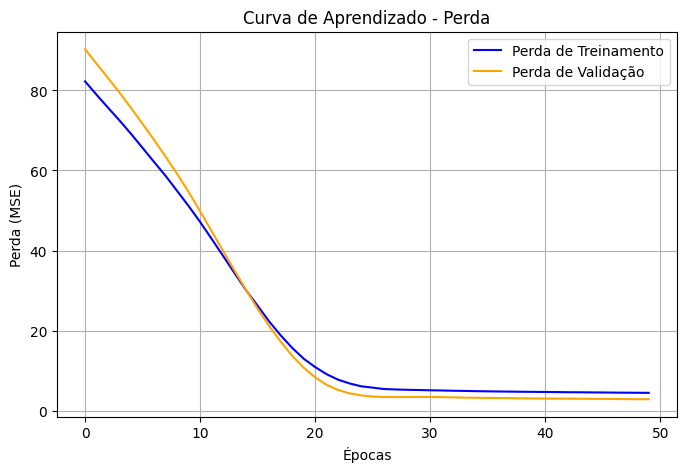

In [26]:
import matplotlib.pyplot as plt

# Curva de aprendizado - Perda no treinamento e validação
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perda de Treinamento', color='blue')
plt.plot(history.history['val_loss'], label='Perda de Validação', color='orange')
plt.title('Curva de Aprendizado - Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda (MSE)')
plt.legend()
plt.grid(True)
plt.show()


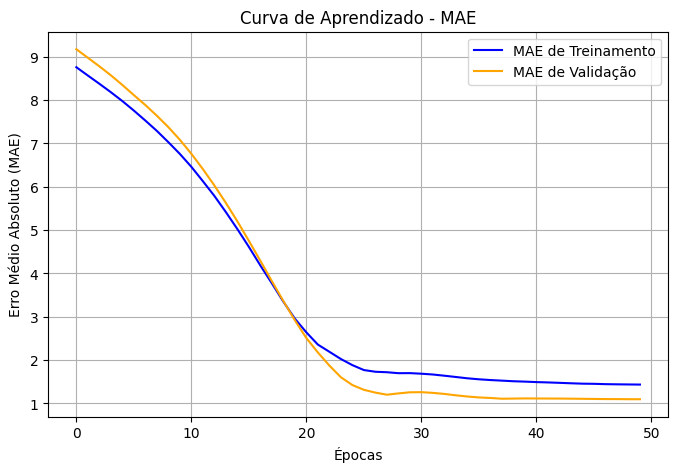

In [27]:
# Precisão do modelo - MAE no treinamento e validação
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='MAE de Treinamento', color='blue')
plt.plot(history.history['val_mae'], label='MAE de Validação', color='orange')
plt.title('Curva de Aprendizado - MAE')
plt.xlabel('Épocas')
plt.ylabel('Erro Médio Absoluto (MAE)')
plt.legend()
plt.grid(True)
plt.show()


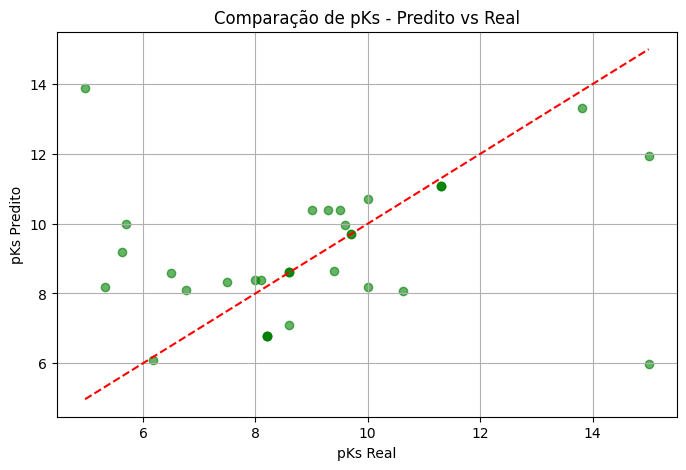

In [28]:
# pKs Predito vs. Real
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_ann, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Linha de referência
plt.title('Comparação de pKs - Predito vs Real')
plt.xlabel('pKs Real')
plt.ylabel('pKs Predito')
plt.grid(True)
plt.show()


In [29]:
# Verificar o tamanho dos conjuntos de dados
print("Número de dados na Rede Neural:")
print(f"Conjunto de Treinamento (X_train): {X_train.shape}")
print(f"Conjunto de Teste (X_test): {X_test.shape}")

# Verificar o número de alvos no treinamento e teste
print(f"Conjunto de Treinamento (y_train): {y_train.shape}")
print(f"Conjunto de Teste (y_test): {y_test.shape}")


Número de dados na Rede Neural:
Conjunto de Treinamento (X_train): (136, 6)
Conjunto de Teste (X_test): (34, 6)
Conjunto de Treinamento (y_train): (136,)
Conjunto de Teste (y_test): (34,)


In [30]:
print(f"Desempenho do Modelo:\nErro Médio Absoluto (MAE): {mae_ann:.3f}\nErro Médio Quadrático (MSE): {mse_ann:.3f}\nPrecisão aproximada (baseada no MAE): {100 - (mae_ann / y_test.mean() * 100):.2f}%")


Desempenho do Modelo:
Erro Médio Absoluto (MAE): 1.608
Erro Médio Quadrático (MSE): 7.121
Precisão aproximada (baseada no MAE): 82.15%


DROPOUT

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Construção do modelo com Dropout
ann_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define a entrada explicitamente
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Saída
])

# Compilação do modelo
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Treinamento do modelo
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 85.1618 - mae: 8.9564 - val_loss: 90.3023 - val_mae: 9.2375
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 79.8139 - mae: 8.6326 - val_loss: 86.1035 - val_mae: 9.0162
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 76.0579 - mae: 8.4066 - val_loss: 81.7304 - val_mae: 8.7784
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 73.8381 - mae: 8.3169 - val_loss: 76.5016 - val_mae: 8.4847
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 67.4210 - mae: 7.8462 - val_loss: 70.0664 - val_mae: 8.1061
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 61.9161 - mae: 7.5704 - val_loss: 61.8817 - val_mae: 7.5955
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 57.3113 - mae: 7.2456 - val_loss: 52.0779 - val_mae: 6.9487
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 44.5847 - mae: 6.2811 - val_loss: 41.1438 - val_mae: 6.1626
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 37.4925

In [33]:
import matplotlib.pyplot as plt
import numpy as np


In [39]:
# Confirmar que o histórico é do modelo atual
print(history.history.keys())


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [40]:
y_pred_ann = ann_model.predict(X_test).flatten()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


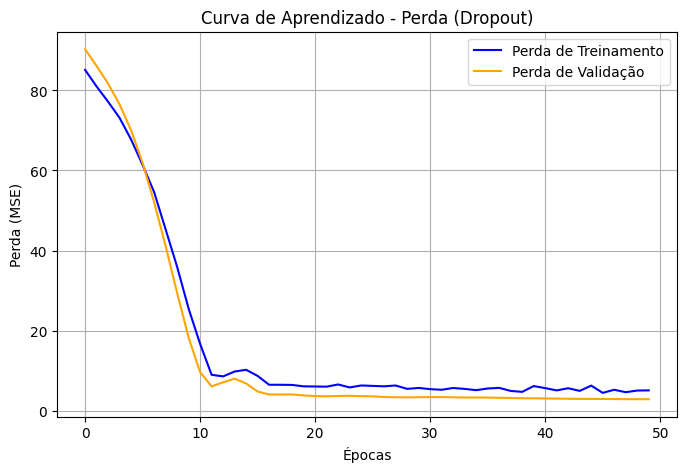

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perda de Treinamento', color='blue')
plt.plot(history.history['val_loss'], label='Perda de Validação', color='orange')
plt.title('Curva de Aprendizado - Perda (Dropout)')
plt.xlabel('Épocas')
plt.ylabel('Perda (MSE)')
plt.legend()
plt.grid(True)
plt.show()


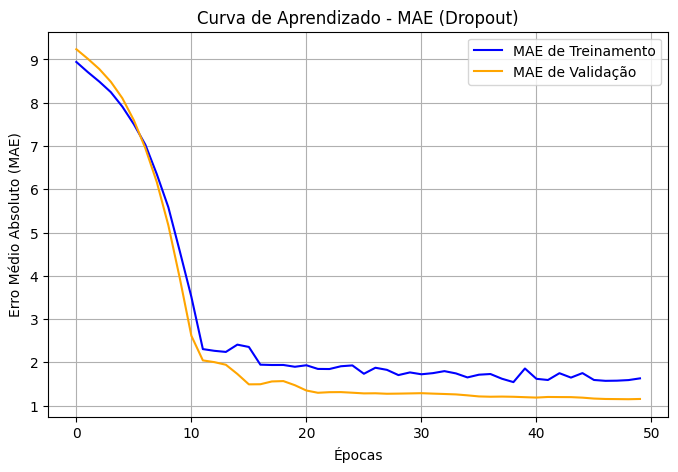

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='MAE de Treinamento', color='blue')
plt.plot(history.history['val_mae'], label='MAE de Validação', color='orange')
plt.title('Curva de Aprendizado - MAE (Dropout)')
plt.xlabel('Épocas')
plt.ylabel('Erro Médio Absoluto (MAE)')
plt.legend()
plt.grid(True)
plt.show()


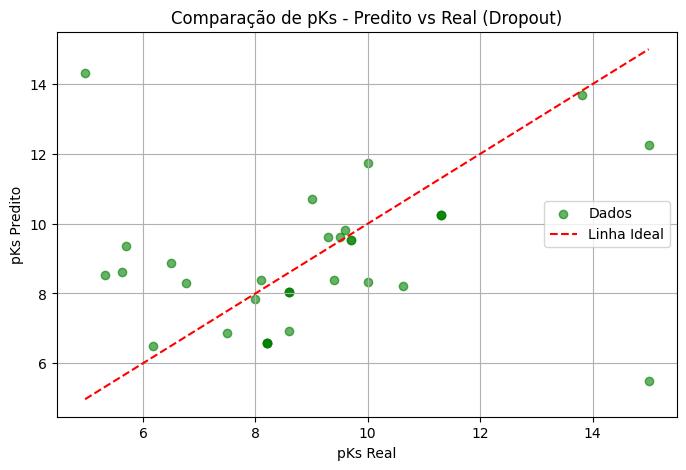

In [43]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_ann, color='green', alpha=0.6, label='Dados')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Linha Ideal')
plt.title('Comparação de pKs - Predito vs Real (Dropout)')
plt.xlabel('pKs Real')
plt.ylabel('pKs Predito')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 5.2121 - mae: 1.6619 - val_loss: 2.8632 - val_mae: 1.1557
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.2486 - mae: 1.4228 - val_loss: 2.9010 - val_mae: 1.1678
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.4378 - mae: 1.6560 - val_loss: 2.8771 - val_mae: 1.1703
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.3811 - mae: 1.6693 - val_loss: 2.8484 - val_mae: 1.1717
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.1549 - mae: 1.5149 - val_loss: 2.8460 - val_mae: 1.1866
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.4206 - mae: 1.6249 - val_loss: 2.8355 - val_mae: 1.1980
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.5040 - mae: 1.7055 - val_loss: 2.8109 - val_mae: 1.1763
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.3883 - mae: 1.5824 - val_loss: 2.7805 - val_mae: 1.1539
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.4226 - mae: 1.6151 - 

In [45]:
y_pred_ann = ann_model.predict(X_test).flatten()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


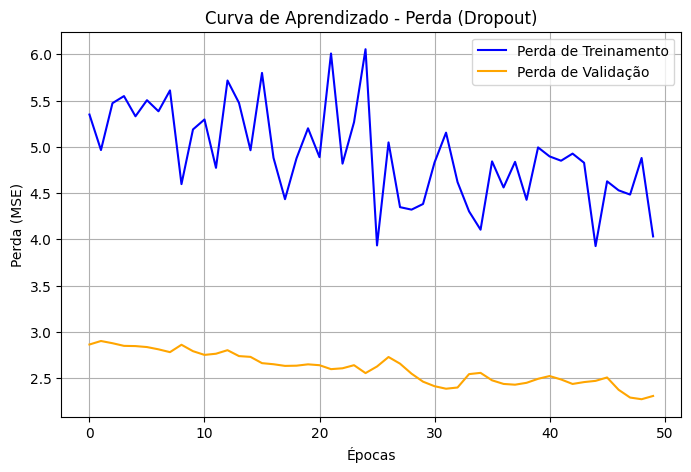

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perda de Treinamento', color='blue')
plt.plot(history.history['val_loss'], label='Perda de Validação', color='orange')
plt.title('Curva de Aprendizado - Perda (Dropout)')
plt.xlabel('Épocas')
plt.ylabel('Perda (MSE)')
plt.legend()
plt.grid(True)
plt.show()


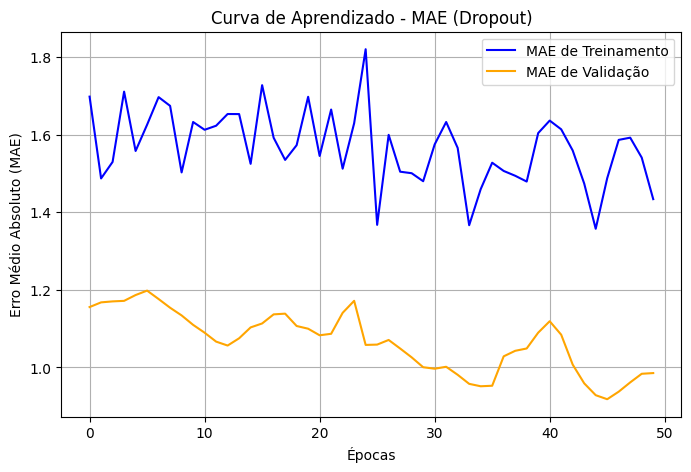

In [47]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='MAE de Treinamento', color='blue')
plt.plot(history.history['val_mae'], label='MAE de Validação', color='orange')
plt.title('Curva de Aprendizado - MAE (Dropout)')
plt.xlabel('Épocas')
plt.ylabel('Erro Médio Absoluto (MAE)')
plt.legend()
plt.grid(True)
plt.show()


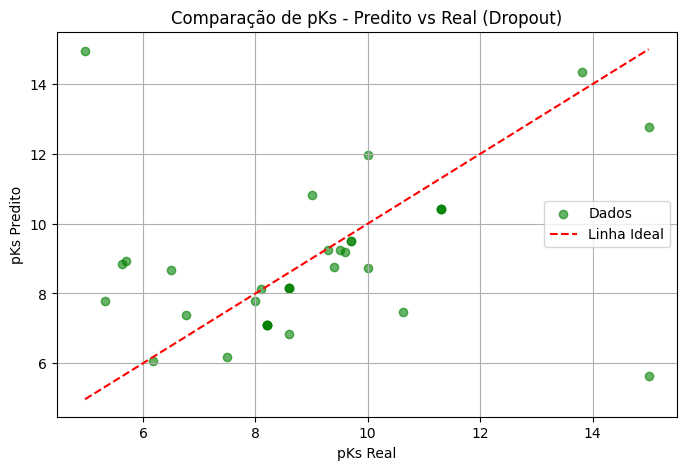

In [48]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_ann, color='green', alpha=0.6, label='Dados')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Linha Ideal')
plt.title('Comparação de pKs - Predito vs Real (Dropout)')
plt.xlabel('pKs Real')
plt.ylabel('pKs Predito')
plt.legend()
plt.grid(True)
plt.show()


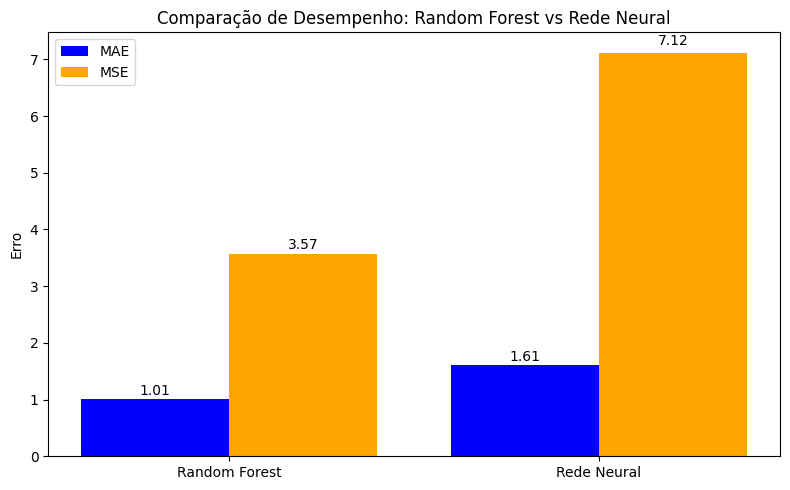

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Resultados dos modelos
modelos = ['Random Forest', 'Rede Neural']
mae = [1.0094309227537233, 1.608293602887322]  # Substitua pelos valores reais
mse = [3.570634430176273, 7.120648111933749]  # Substitua pelos valores reais

# Configuração do gráfico
x = np.arange(len(modelos))
width = 0.4

fig, ax = plt.subplots(figsize=(8, 5))

# Barras para MAE
rects1 = ax.bar(x - width/2, mae, width, label='MAE', color='blue')

# Barras para MSE
rects2 = ax.bar(x + width/2, mse, width, label='MSE', color='orange')

# Adicionar títulos e legendas
ax.set_title('Comparação de Desempenho: Random Forest vs Rede Neural')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.set_ylabel('Erro')
ax.legend()

# Adicionar valores acima das barras
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
            f'{height:.2f}', ha='center', va='bottom')

# Exibir gráfico
plt.tight_layout()
plt.show()


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Definir o modelo
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Saída
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Treinamento
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100


C:\Users\idmpi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 81.8533 - mae: 8.7488 - val_loss: 86.9096 - val_mae: 9.0591 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 77.2564 - mae: 8.5472 - val_loss: 81.0368 - val_mae: 8.7339 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 68.9136 - mae: 7.9918 - val_loss: 73.9002 - val_mae: 8.3228 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 63.2176 - mae: 7.6123 - val_loss: 65.3899 - val_mae: 7.8036 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 57.7275 - mae: 7.2526 - val_loss: 55.3831 - val_mae: 7.1810 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 49.2658 - mae: 6.6347 - val_loss: 43.9496 - val_mae: 6.3955 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 38.9810 - mae: 5.7756 - val_loss: 31.9221 - val_mae: 5.4307 - learning_rate: 0.0010
Epoch 8/100
4/4 ━━

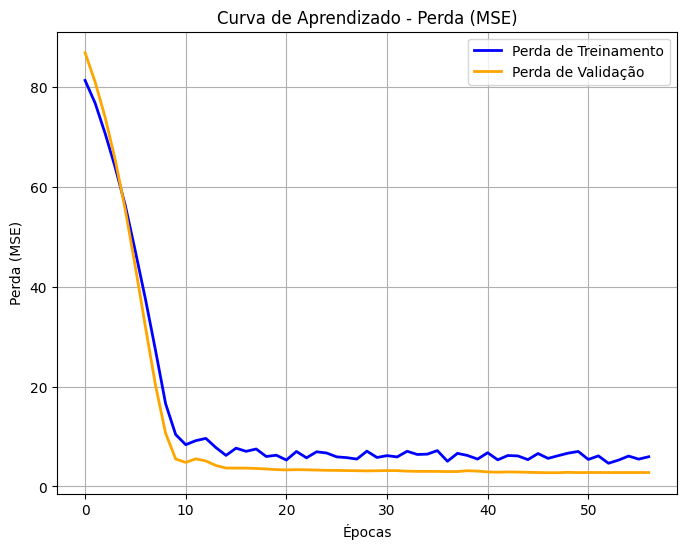

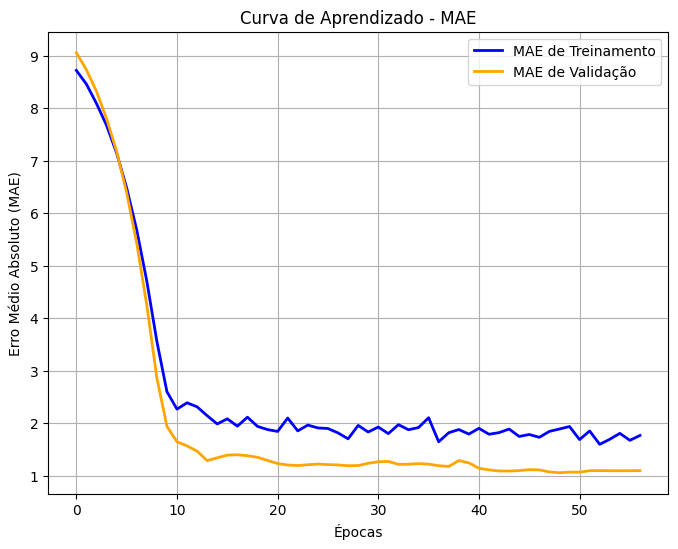

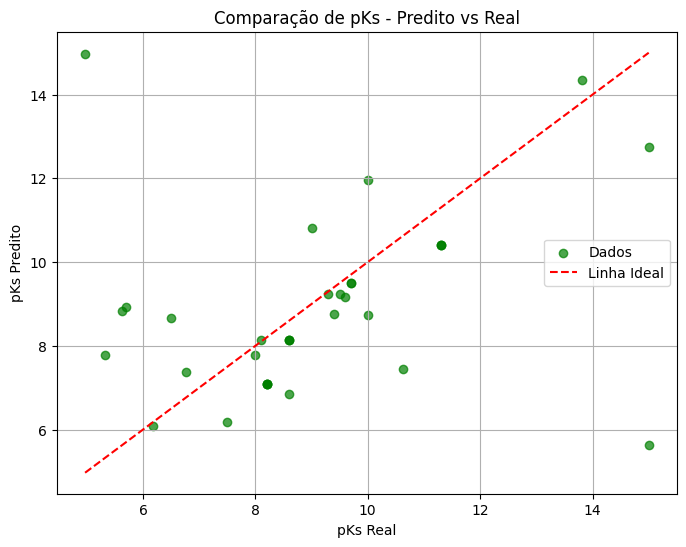

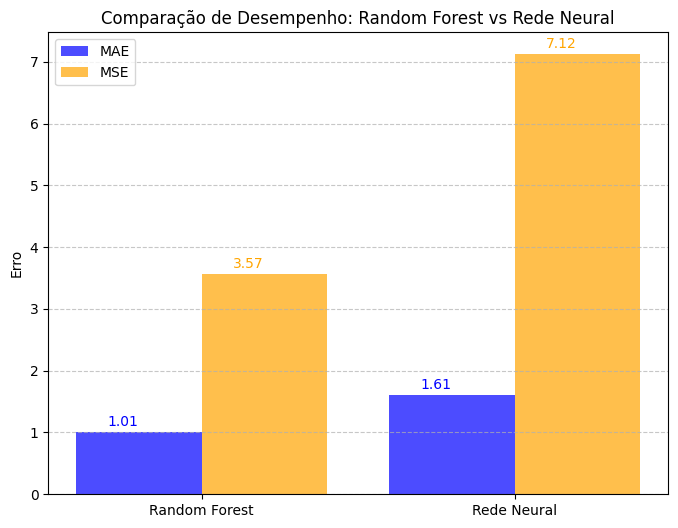

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Gráfico 1: Curva de aprendizado (Perda)
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Perda de Validação', color='orange', linewidth=2)
plt.title("Curva de Aprendizado - Perda (MSE)")
plt.xlabel("Épocas")
plt.ylabel("Perda (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2: Curva de aprendizado (MAE)
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='MAE de Treinamento', color='blue', linewidth=2)
plt.plot(history.history['val_mae'], label='MAE de Validação', color='orange', linewidth=2)
plt.title("Curva de Aprendizado - MAE")
plt.xlabel("Épocas")
plt.ylabel("Erro Médio Absoluto (MAE)")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 3: Scatter Plot de valores reais vs preditos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ann, color='green', alpha=0.7, label='Dados')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Linha Ideal')
plt.title("Comparação de pKs - Predito vs Real")
plt.xlabel("pKs Real")
plt.ylabel("pKs Predito")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 4: Comparação entre Random Forest e Redes Neurais
model_names = ['Random Forest', 'Rede Neural']
mae_values = [mae_rf, mae_ann]
mse_values = [mse_rf, mse_ann]

x = np.arange(len(model_names))
width = 0.4

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, mae_values, width, label='MAE', color='blue', alpha=0.7)
plt.bar(x + width/2, mse_values, width, label='MSE', color='orange', alpha=0.7)

for i, v in enumerate(mae_values):
    plt.text(i - 0.25, v + 0.1, f"{v:.2f}", color='blue', ha='center')
for i, v in enumerate(mse_values):
    plt.text(i + 0.15, v + 0.1, f"{v:.2f}", color='orange', ha='center')

plt.title("Comparação de Desempenho: Random Forest vs Rede Neural")
plt.xticks(x, model_names)
plt.ylabel("Erro")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


DNN


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Modelo DNN com mais camadas
dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Regularização
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Saída com um único valor
])

# Compilar o modelo
dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Treinar o modelo
history_dnn = dnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/100


C:\Users\idmpi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 82.1211 - mae: 8.8051 - val_loss: 84.7759 - val_mae: 8.9563
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 77.3842 - mae: 8.5410 - val_loss: 78.2177 - val_mae: 8.5998
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 73.0088 - mae: 8.1798 - val_loss: 70.7686 - val_mae: 8.1750
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 64.2448 - mae: 7.6966 - val_loss: 61.9516 - val_mae: 7.6393
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 58.1904 - mae: 7.2937 - val_loss: 51.7660 - val_mae: 6.9622
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 49.8267 - mae: 6.7179 - val_loss: 40.3844 - val_mae: 6.1297
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 40.1723 - mae: 5.9458 - val_loss: 28.4606 - val_mae: 5.1085
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 25.9622 - mae: 4.6877 - val_loss: 17.2723 - val_mae: 3.8653
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 19.6820 - 

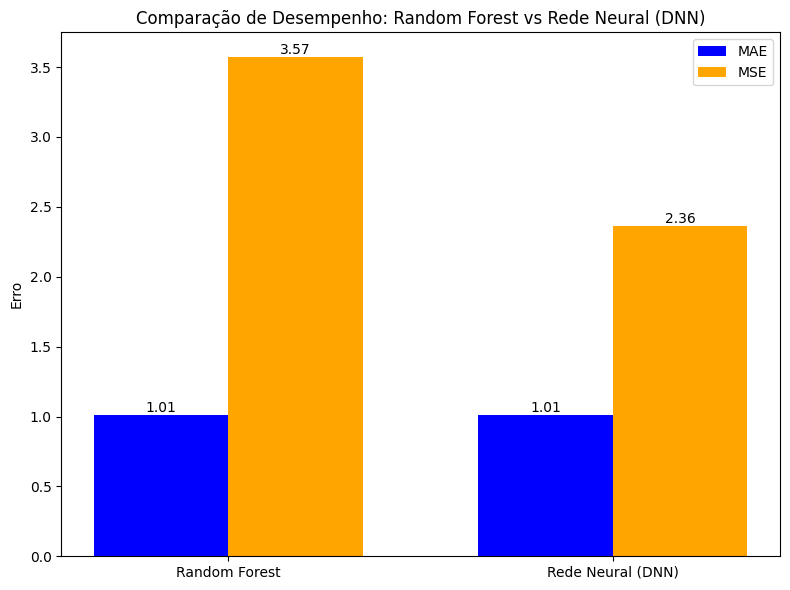

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Resultados da Random Forest
mae_rf = 1.01  # Substitua pelos valores exatos do seu modelo RF
mse_rf = 3.57

# Resultados da Rede Neural (DNN)
mae_dnn = 1.0121  # Substitua pelo MAE da DNN
mse_dnn = 2.3647  # Substitua pelo MSE da DNN

# Dados para o gráfico
modelos = ['Random Forest', 'Rede Neural (DNN)']
mae = [mae_rf, mae_dnn]
mse = [mse_rf, mse_dnn]

# Plotando o gráfico de comparação
x = np.arange(len(modelos))  # Posições no eixo X
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(8, 6))

# Barras de MAE
rects1 = ax.bar(x - width/2, mae, width, label='MAE', color='blue')
# Barras de MSE
rects2 = ax.bar(x + width/2, mse, width, label='MSE', color='orange')

# Adicionando detalhes
ax.set_ylabel('Erro')
ax.set_title('Comparação de Desempenho: Random Forest vs Rede Neural (DNN)')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()

# Adicionando os valores acima das barras
for rect in rects1:
    ax.text(rect.get_x() + rect.get_width()/2., rect.get_height(), f'{rect.get_height():.2f}', 
            ha='center', va='bottom', fontsize=10)

for rect in rects2:
    ax.text(rect.get_x() + rect.get_width()/2., rect.get_height(), f'{rect.get_height():.2f}', 
            ha='center', va='bottom', fontsize=10)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Certifique-se de que `y_test` e `y_pred_dnn` são definidos corretamente.
# Substitua `y_test` e `y_pred` pelos valores do conjunto de teste e previsões do seu modelo DNN.

# Valores reais (pKs real)
y_real = y_test  # Certifique-se de que y_test está definido no ambiente

# Valores previstos pelo modelo DNN (pKs previsto)
y_pred_dnn = model.predict(X_test).flatten()  # Gere as previsões com seu modelo DNN

# Verifique se os dados estão disponíveis e possuem o mesmo tamanho
if len(y_real) != len(y_pred_dnn):
    print("Erro: O número de valores reais e previstos não corresponde. Verifique os dados.")
else:
    # Plotando o gráfico
    plt.figure(figsize=(8, 6))
    plt.scatter(y_real, y_pred_dnn, color='green', label='Dados', alpha=0.6)
    plt.plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--', label='Linha Ideal')
    plt.title('Comparação de pKs - Previsto vs Real (DNN)')
    plt.xlabel('pKs Real')
    plt.ylabel('pKs Previsto')
    plt.legend()
    plt.grid(True)
    plt.show()
